## Overview: Analysis using NLME package (flexibility to deal with heteroscedasticity)

### Steps
1. Install packages and load libraries
1. Set working directory and import data
1. Replace 999/777 in income and education 
1. Create puberty variable (merge male/female puberty)
1. Specify data type (numeric/factor/ordinal)
1. Copy smri variables and change colnames before winsorization 
1. Standardize smri_vol variables
1. Winsorize smri vol variables
1. Loop over dependent variables 
1. Explore error structures to deal with heteroscedasticity


#### 1. Install packages and load libraries

In [68]:
if (!('nlme'      %in% installed.packages()[,"Package"])) install.packages('nlme')
if (!('lattice'   %in% installed.packages()[,"Package"])) install.packages('lattice')
if (!('dplyr'     %in% installed.packages()[,"Package"])) install.packages('dplyr')
if (!('survey'    %in% installed.packages()[,"Package"])) install.packages('survey')
if (!('naniar'    %in% installed.packages()[,"Package"])) install.packages('naniar')
if (!('pander'    %in% installed.packages()[,"Package"])) install.packages('pander')
if (!('tidyverse' %in% installed.packages()[,"Package"])) install.packages('tidyverse')
if (!('broom'     %in% installed.packages()[,"Package"])) install.packages('broom')
if (!('robustHD'  %in% installed.packages()[,"Package"])) install.packages('robustHD')


if(!"nlme"      %in% .packages())     library(nlme)
if(!"lattice"   %in% .packages())  library(lattice)
if(!"dplyr"     %in% .packages())    library(dplyr)
if(!"survey"    %in% .packages())    library(survey)
if(!"naniar"    %in% .packages())    library(naniar)
if(!"pander"    %in% .packages())    library(pander)
if(!"tidyverse" %in% .packages()) library(tidyverse)
if(!"broom"     %in% .packages())     library(broom)
if(!"robustHD"  %in% .packages())  library(robustHD)

#### 2. Set working directory and import data

In [69]:
#set working directory to import PsychRisk3.tsv file that was created with the psychrisk_exploration.ipynb notebook
setwd("/shared/project-psychopathology-risk/outputs/exploration/")
df <- read.table(file = 'PsychRisk_data.tsv', sep = '\t', header = TRUE)

#### 3. Data preparation
1. specify missing values
1. create puberty variable

In [70]:
# replace value 999 and 777 (don't know and refused to answer) to NA
df <- df %>%
  replace_with_na(replace = list(demo_comb_income_v2 = c(999, 777), 
                                 demo_prnt_ed_v2 = c(777)))

In [71]:
# create puberty variable
df$puberty <- ifelse(!is.na(df$pds_p_ss_female_category),df$pds_p_ss_female_category,df$pds_p_ss_male_category)
table(df$puberty, exclude=NULL)  #364 NAs


   1    2    3    4    5 <NA> 
5291 2408 2366  152    8  364 

#### 4. Specify data type (numeric/factor/ordinal)

In [72]:
# drop variables that are not needed. Do not change because names1 will not be correct anymore. 
drop <- c("pds_p_ss_female_category", "pds_p_ss_male_category", "eventname", "mri_info_deviceserialnumber", "iqc_t1_ok_ser", "fsqc_qc", "mrif_score", "demo_prim")
df2 = df[,!(names(df) %in% drop)]

In [73]:
#Specify data types
names1 <- c(1,4,5, 7,8, 25:45, 187:193) #column numbers factor variables
df2[names1]<- lapply(df2[names1],factor)
df2$interview_date <- as.Date(df2$interview_date, "%m/%d/%Y") 
df2$interview_age <- as.numeric(df2$interview_age) 
df2$demo_comb_income_v2 <- factor(df2$demo_comb_income_v2, order = TRUE)
df2$demo_prnt_ed_v2 <- factor(df2$demo_prnt_ed_v2, order = TRUE)
df2$puberty <- factor(df2$puberty, order = TRUE)

In [74]:
str(df2, list.len=ncol(df2)) #sanity check

'data.frame':	10589 obs. of  194 variables:
 $ subjectkey                   : Factor w/ 10589 levels "NDAR_INV003RTV85",..: 9 22 25 35 39 43 48 55 68 86 ...
 $ interview_date               : Date, format: "2017-08-19" "2017-08-09" ...
 $ interview_age                : num  121 129 122 122 126 128 128 120 122 127 ...
 $ sex                          : Factor w/ 2 levels "F","M": 2 2 1 2 1 2 1 1 2 1 ...
 $ rel_family_id                : Factor w/ 8834 levels "1","3","4","5",..: 6129 661 8524 6485 6130 7273 2425 6486 8525 6490 ...
 $ acs_raked_propensity_score   : num  616 426 322 428 959 ...
 $ race_ethnicity               : Factor w/ 5 levels "1","2","3","4",..: 5 1 1 1 1 1 1 3 1 1 ...
 $ site_id_l                    : Factor w/ 22 levels "site01","site02",..: 11 16 2 6 11 9 14 6 2 6 ...
 $ smri_vol_scs_aal             : num  525 535 522 484 535 ...
 $ smri_vol_scs_aar             : num  580 646 579 622 557 ...
 $ smri_vol_scs_amygdalalh      : num  1668 1430 1514 1404 1905 ...
 $ smri_v

Scaled  155  variable(s)


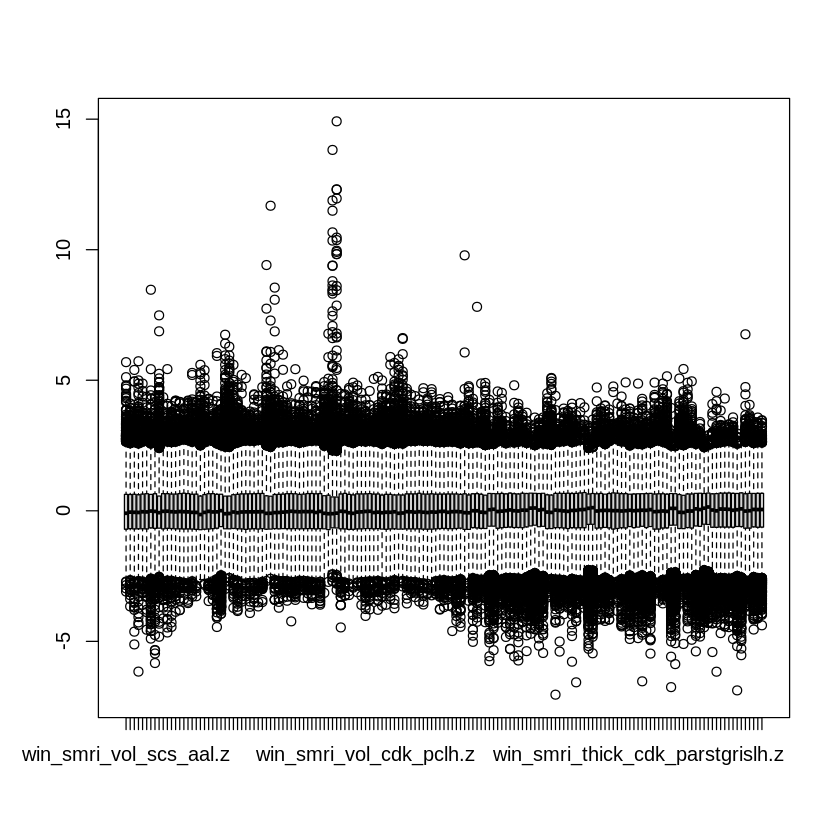

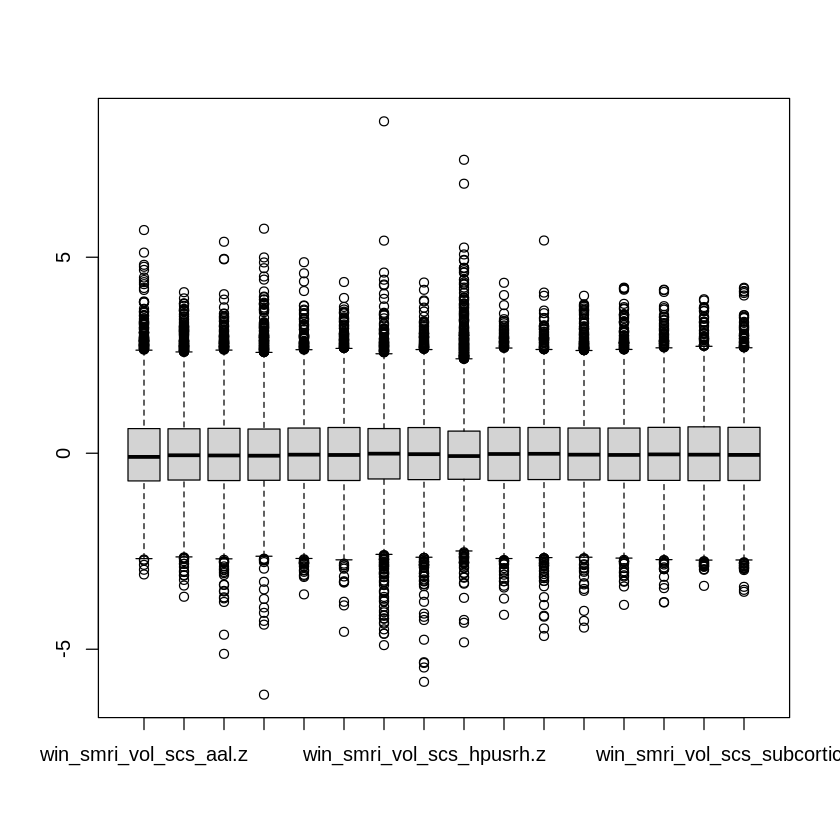

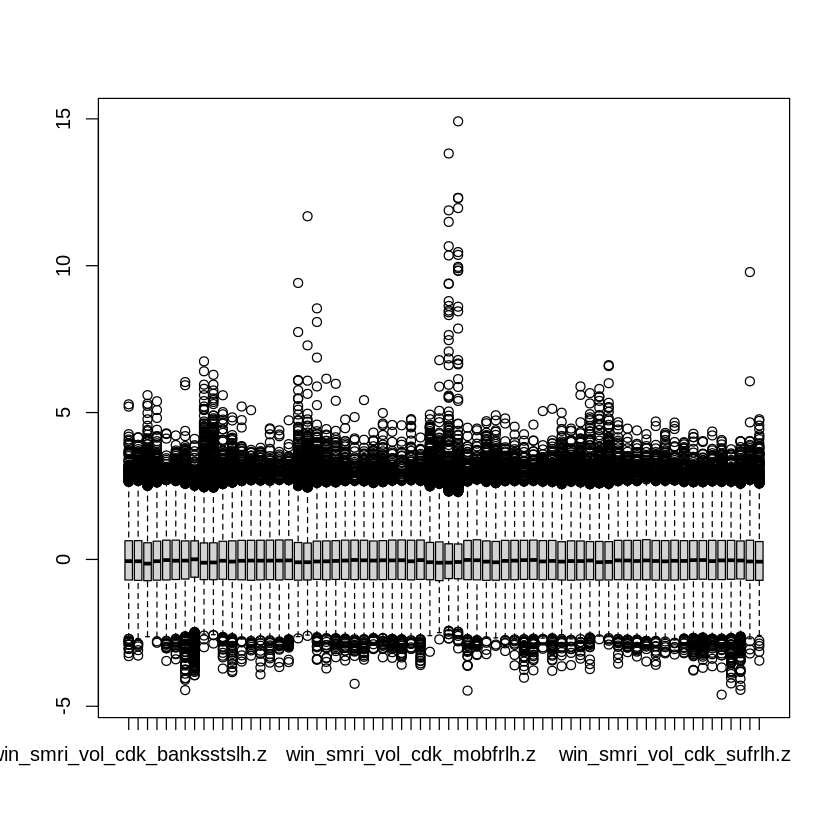

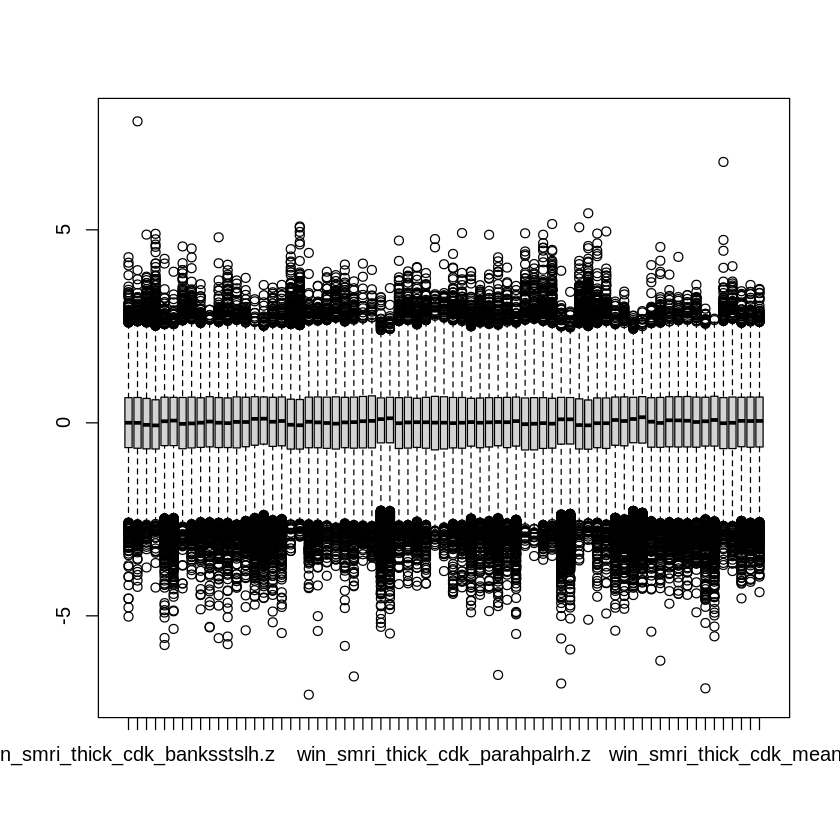

In [75]:
#create new df with smri variables and add win prefix to column names 
smri <- df2[grepl("^smri_", colnames(df2))] 
colnames(smri) <-paste("win",colnames(smri),sep="_") 

#standardization function
scale.many <- function(dat, column.nos) {
  nms <- names(dat)
  for(col in column.nos) {
    name <- paste(nms[col],".z", sep = "")
    dat[name] <- scale(dat[,col])
  }
  cat(paste("Scaled ", length(column.nos), " variable(s)\n"))
  dat
}

#standardize smri variables
smri_w <- scale.many(smri, c(1:155))

#keep standarized only
smri_w <- smri_w[ -c(1:155) ] #keep standardized variables only
boxplot(smri_w)  #all
boxplot(smri_w[1:16]) #subcortical volume
boxplot(smri_w[17:84]) #cortical volume
boxplot(smri_w[85:155]) #cortical thickness

In [76]:
#### 7. Winsorize smri vol and thickness variables if 3sd above or below mean

Scaled  2  variable(s)


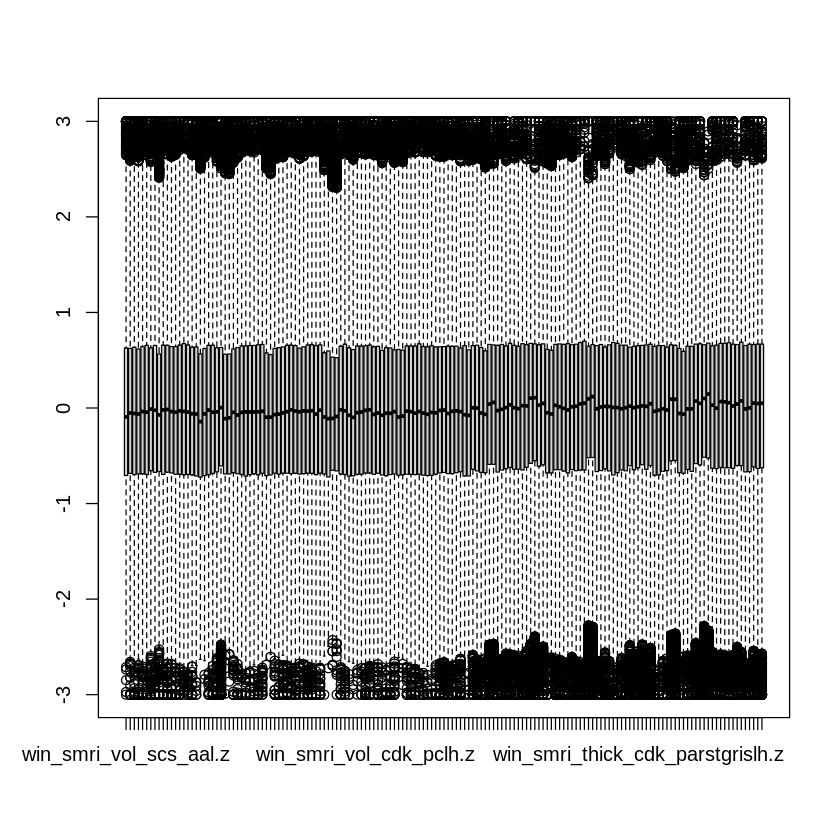

In [77]:
df3 <- smri_w
    
# Winsorization function
fun <- function(x){
    x[ x < -3 ] <- -3
    x[ x > 3 ] <- 3
    x
}

# Apply winsorization 
df3 <- fun(df3)
boxplot(df3) #check whether all values are within -3 and +3

# combine dataframes and standardize age
df4 <- cbind(df2, df3)
df4 <- scale.many(df4, c(3, 6)) #standardized age and acs_propensity